# 1. Basic Setup

In [2]:
# mediapipe: Able to get keypoints from the body
# scikit-learn: Tools for predictive data analysis

In [3]:
pip install tensorflow opencv-python matplotlib mediapipe scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp

# 2. Drawing Keypoints using MP

In [5]:
mp_holistic = mp.solutions.holistic # Make detections (pose, hands, face etc.)
mp_drawing = mp.solutions.drawing_utils # Draw keypoints
mp_face_mesh = mp.solutions.face_mesh # For Face connections (keypoints)

In [6]:
def mp_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    # Tells NumPy/OpenCV that I won’t modify the image during processing, 
    # which can save memory copying and speed things up
    results = model.process(image)
    image.flags.writeable = True # So I can draw on it later
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
# mp_holistic.POSE_CONNECTIONS?? # Shows the connection map, a relationship between landmarks

In [8]:
def draw_developed_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255, 212, 116), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(138, 89, 16), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255, 134, 124), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(215, 45, 67), thickness=2, circle_radius=2))

In [9]:
# Webcam setting 
cap = cv2.VideoCapture(0) # Access a device index, 0 is the default (webcam)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): # While accessing my webcam
        ret, frame = cap.read() # Read feed # Return value, frame (image value)
        
        image, results = mp_detection(frame, holistic)
        # print(results)

        draw_developed_landmarks(image, results)
        
        cv2.imshow('OpenCV Feed', image) # Show frame to my screen
        
        if cv2.waitKey(10) & 0xFF == ord('q'): break # Break this loop if keyboard key q is pressed
        # Waits 10 ms for a key event, returns integer representing the key pressed, -1 if not. 
cap.release()
cv2.destroyAllWindows()

In [10]:
# results.face_landmarks      # returns dictionary, landmark: x, y, z values
# results.face_landmarks.landmark        # returns array, x, y, z values
# len(results.face_landmarks.landmark)   # number of total keypoints a face has
# print(len(results.left_hand_landmarks.landmark))
# If you try to access a landmark that wasn’t present on the webcam, it will throw an error

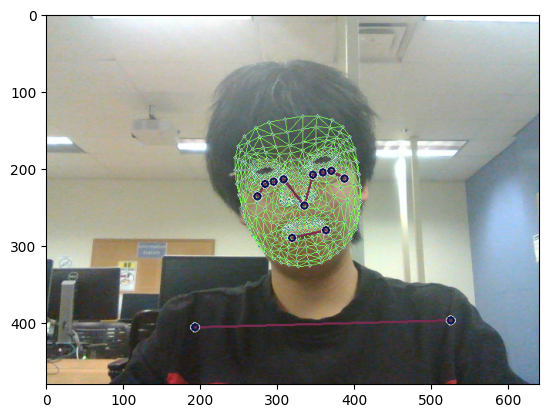

In [11]:
draw_developed_landmarks(image, results)
# draw_landmarks doesn't return the image, but applies the landmark visualizations to the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [12]:
# Into numpy
# results.pose_landmarks.landmark[0].visibility

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    # pose, len(pose) = 33*4, pose.shape = (132,)
    lefth = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    righth = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    return np.concatenate([pose, face, lefth, righth])

In [13]:
extract_keypoints(results).shape

(1662,)

# 4. Folders for Data

**Action Detection**: Uses sequence of data(frames) rather than a single frame. 

In [14]:
PATH = os.path.join('MP_Data')
actions = np.array(['Hello', 'Thanks', 'IloveYou'])

# I will use 30 frames to detect sign language
no_sequences = 30       # Thirty videos worth of data
sequence_length = 30    # Videos are going to be 30 frames in length

# 30 videos * 30 frames * 3 actions * 1662 keypoints = data size

In [18]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(PATH, action, str(sequence)))
        except:
            pass

# 5. Collecting Keypoint Values for Training and Testing

In [19]:
# Webcam setting 
cap = cv2.VideoCapture(0) # Access a device index, 0 is the default (webcam)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions: # While accessing my webcam
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read() # Read feed # Return value, frame (image value)
                
                image, results = mp_detection(frame, holistic)
                # print(results)
        
                draw_developed_landmarks(image, results)

                if frame_num == 0: # If I'm at frame 0, take a break for 2000 ms
                    # Outputting text on screen
                    # (120, 200): position, font, font_size, font_color(BGR), line width, line_type 
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence),
                                (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence),
                                (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    
                keypoints = extract_keypoints(results)
                np_path = os.path.join(PATH, action, str(sequence), str(frame_num))
                np.save(np_path, keypoints)
                # np.load(<file name>)
                
                cv2.imshow('OpenCV Feed', image) # Show frame to my screen
                    
                if cv2.waitKey(10) & 0xFF == ord('q'): break # Break this loop if keyboard key q is pressed
                # Waits 10 ms for a key event, returns integer representing the key pressed, -1 if not. 
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data, Create Features, and Labeling

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [25]:
label_map = {label:ind for ind, label in enumerate(actions)}

sequences, labels = [], [] # 1 sequence = 1 video
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            loc = np.load(os.path.join(PATH, action, str(sequence), '{}.npy'.format(str(frame_num))))
            window.append(loc)
        sequences.append(window)
        labels.append(label_map[action])

In [29]:
print(np.array(sequences).shape) # 30videos * 3actions = 90videos, 1video = 30frames, 1frame = 1662landmarks
print(np.array(labels).shape)

(90, 30, 1662)
(90,)


In [38]:
x = np.array(sequences)
y = to_categorical(labels).astype(int) # convert a class vector (integers) to binary class metrix 

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05) # 85, 5

# 7. Building and Training LSTM Neural Network